In [2]:
import tensorflow as tf
import os

In [3]:
cpus = tf.config.experimental.list_physical_devices('CPU')
cpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [4]:
cpus = tf.config.experimental.list_physical_devices('GPU')
for cpu in cpus:
    tf.config.experimental.set_memory_growth(cpu, True)

In [5]:
import cv2
import imghdr
import matplotlib.pyplot as plt
import numpy as np

C:\Users\KIIT\AppData\Local\Temp\ipykernel_34180\3538499753.py:2: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


In [6]:
data_dir = 'dataset'

In [7]:
os.listdir(os.path.join(data_dir, 'normal'))

['row_10.png',
 'row_11.png',
 'row_12.png',
 'row_13.png',
 'row_14.png',
 'row_15.png',
 'row_25.png',
 'row_26.png',
 'row_27.png',
 'row_28.png',
 'row_29.png',
 'row_32.png',
 'row_33.png',
 'row_34.png',
 'row_35.png',
 'row_36.png',
 'row_37.png',
 'row_38.png',
 'row_39.png',
 'row_7.png',
 'row_8.png',
 'row_9.png',
 'st_CAB_output.jpg']

In [8]:
image_exts = ['jpeg','jpg', 'bmp', 'png']

In [9]:
image_exts

['jpeg', 'jpg', 'bmp', 'png']

In [10]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

**Load Data**

In [11]:
tf.data.Dataset

tensorflow.python.data.ops.dataset_ops.DatasetV2

In [12]:
#tf.keras.utils.image_dataset_from_directory??

In [13]:
# --- 1. Define 'data' ---
data = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels='inferred',  # Infers labels from directory structure
    label_mode='categorical',  # One-hot encoded labels
    image_size=(256, 256),  # Adjust if your images have different dimensions
    batch_size=8,  # Adjust based on your memory constraints
)

Found 39 files belonging to 3 classes.


In [14]:
data_iterator = data.as_numpy_iterator()

In [15]:
batch = data_iterator.next()

In [16]:
batch[0].shape

(8, 256, 256, 3)

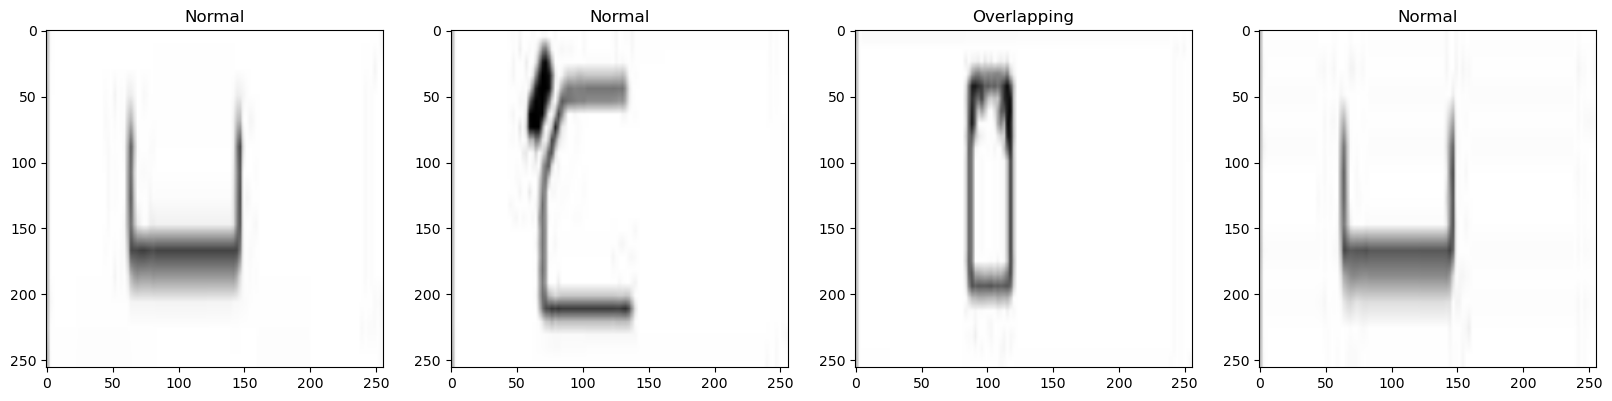

In [17]:
class_names = {
    0: "Circular",
    1: "Normal",
    2: "Overlapping"
}


fig, ax = plt.subplots(ncols=4, figsize=(20, 25))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    # Convert NumPy array to a hashable type (e.g., integer)
    label_index = np.argmax(batch[1][idx])  # Get index of the highest probability class
    ax[idx].title.set_text(class_names.get(label_index, "Unknown"))

    # Add x and y ticks (adjust values based on your image dimensions)
    ax[idx].set_xticks(np.arange(0, img.shape[1], 50))  # Ticks every 50 pixels on x-axis
    ax[idx].set_yticks(np.arange(0, img.shape[0], 50))  # Ticks every 50 pixels on y-axis

    # Optionally, label the ticks with pixel values
    ax[idx].set_xticklabels(np.arange(0, img.shape[1], 50))
    ax[idx].set_yticklabels(np.arange(0, img.shape[0], 50))

plt.show()

**Scale Data**

In [18]:
data = data.map(lambda x,y: (x/255, y))
# important since it helps to perform transformation to convert image min to 0 and max to 1
# important while working with data pipeline

In [19]:
data.as_numpy_iterator().next()

(array([[[[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         [[1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          ...,
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ],
          [1.        , 1.        , 1.        ]],
 
         ...,
 
         [[1.        , 1.        , 1.        ],
          [1.     

**Split Data**

In [20]:
len(data) # num of batches

5

In [21]:
#batch_size = 32

In [22]:
# train_batches = int(len(data) * 0.7) // batch_size
# val_batches = int(len(data) * 0.2) // batch_size
# test_batches = int(len(data) * 0.1) // batch_size

In [23]:
# test_batches

In [24]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)+1

In [25]:
val_size

1

In [26]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Established train, test and val partition

In [27]:
train_labels = np.concatenate([y for x, y in train], axis=0)
val_labels = np.concatenate([y for x, y in val], axis=0)
test_labels = np.concatenate([y for x, y in test], axis=0)

# One-hot encode the labels (if needed for your model)
train_labels = tf.keras.utils.to_categorical(train_labels)
val_labels = tf.keras.utils.to_categorical(val_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

**Building the Deep Learning Model**

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [29]:
num_classes = 3
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(32, (3,3), 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Conv2D(16, (3,3), 1, activation='relu'))
model.add(tf.keras.layers.MaxPooling2D())
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

C:\Users\KIIT\anaconda3\envs\ai_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 254, 254, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 14400)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,686,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,697,139 (14.10 MB)

 Trainable params: 3,697,139 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

**Train**

In [32]:
logdir = 'logs'

In [33]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [34]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 497ms/step - accuracy: 0.3281 - loss: 3.3627 - val_accuracy: 0.3750 - val_loss: 2.7548
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.3073 - loss: 1.1129 - val_accuracy: 0.2500 - val_loss: 1.0579
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 171ms/step - accuracy: 0.3438 - loss: 1.0557 - val_accuracy: 0.6250 - val_loss: 0.9771
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 191ms/step - accuracy: 0.5365 - loss: 1.0652 - val_accuracy: 0.5000 - val_loss: 1.0440
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.6510 - loss: 0.9784 - val_accuracy: 0.6250 - val_loss: 0.8945
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - accuracy: 0.6823 - loss: 0.8364 - val_accuracy: 0.5000 - val_loss: 1.2313
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 160ms/step - accuracy: 0.5729 - loss: 1.1136 - val_accuracy: 0.6250 - val_loss: 0.8407
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 193ms/step - accuracy: 0.5417 - loss: 0.9339 - val_accuracy: 1.0000 - val_loss:

In [35]:
hist.history

{'accuracy': [0.375,
  0.3333333432674408,
  0.375,
  0.5416666865348816,
  0.5833333134651184,
  0.7083333134651184,
  0.5833333134651184,
  0.5833333134651184,
  0.5833333134651184,
  0.6666666865348816,
  0.75,
  0.6666666865348816,
  0.9166666865348816,
  0.8333333134651184,
  0.9166666865348816,
  0.9166666865348816,
  1.0,
  1.0,
  1.0,
  1.0],
 'loss': [3.956157684326172,
  1.121780276298523,
  1.0633069276809692,
  1.0752209424972534,
  0.9913738369941711,
  0.7910131812095642,
  1.0143003463745117,
  0.9207783341407776,
  0.8559834957122803,
  0.7149405479431152,
  0.5875482559204102,
  0.5894535183906555,
  0.36755308508872986,
  0.3763491213321686,
  0.2963222861289978,
  0.2603754699230194,
  0.11632760614156723,
  0.0765240415930748,
  0.06220901012420654,
  0.021825119853019714],
 'val_accuracy': [0.375,
  0.25,
  0.625,
  0.5,
  0.625,
  0.5,
  0.625,
  1.0,
  0.5,
  0.875,
  0.625,
  0.875,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  1.0,
  0.875,
  0.875],
 'val_loss': [2.754

**Plot Performance**

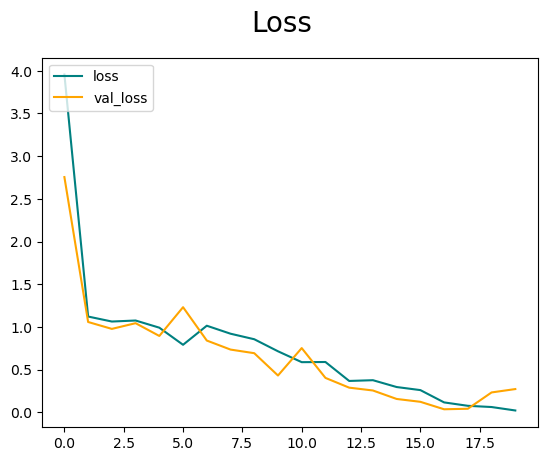

In [36]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

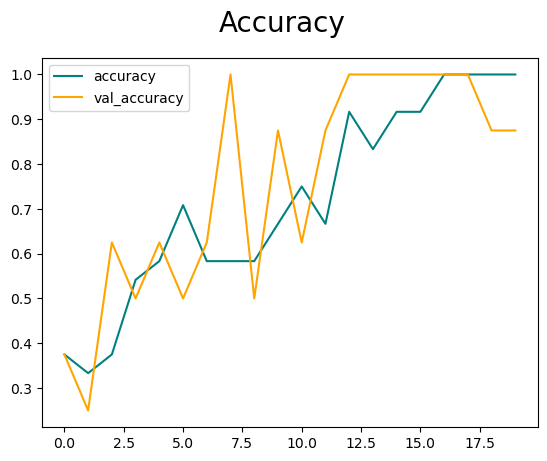

In [37]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

**Evaluate Performance**

In [38]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [39]:
# Establishing instances
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [40]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step


In [41]:
print(f'Precision:{pre.result()}, Recall:{re.result().numpy()}, Acuraccy:{acc.result().numpy}')

Precision:1.0, Recall:1.0, Acuraccy:<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(), dtype=float32, numpy=1.0>>


**Test**

In [42]:
import cv2

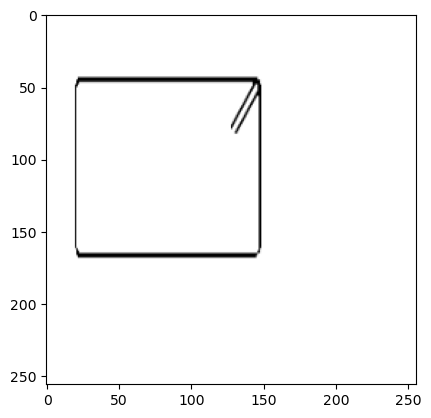

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
Image belong to the Overlapping class


In [53]:
# Load and preprocess the image
img = cv2.imread('eval3.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

# Predict the class
predict = model.predict(np.expand_dims(resize/255, 0))

class_names = ['Circular', 'Normal', 'Overlapping']
predicted_class = np.argmax(predict)

print(f'Image belong to the {class_names[predicted_class]} class')

**Saving the model**

In [44]:
from tensorflow.keras.models import load_model

In [45]:
model.save('imageclassifier.keras')

In [46]:
prediction = tf.keras.models.load_model('imageclassifier.keras')

In [47]:
prediction

<Sequential name=sequential, built=True>

In [49]:
yhatnew = prediction.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


In [54]:
class_names = ['Circular', 'Normal', 'Overlapping']
predicted_class = np.argmax(predict)

print(f'Image belong to the {class_names[predicted_class]} class')

Image belong to the Overlapping class
